<a href="https://colab.research.google.com/github/Ash4dev/melody_europa/blob/main/melody_generation_erk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Ash4dev/expert-octo-garbanzo.git

Cloning into 'expert-octo-garbanzo'...
remote: Enumerating objects: 8539, done.
remote: Counting objects: 100% (8539/8539), done.
remote: Compressing objects: 100% (8344/8344), done.
remote: Total 8539 (delta 203), reused 8516 (delta 194), pack-reused 0
Receiving objects: 100% (8539/8539), 8.76 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [2]:
# set-ups for the music21 library

# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...
done!
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



In [3]:
import music21
from IPython.display import Image, Audio

In [ ]:
def show_score(music):
  display(Image(str(music.write('lily.png'))))

def play_score(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

In [ ]:
# proof of work
n = music21.note.Note('D#3')
n.duration.type = 'half'
show_score(n)
play_score(n)

littleMelody = music21.converter.parse('tinynotation: 3/4 c4 d8 f g16 a b f#')
show_score(littleMelody)
play_score(littleMelody)

bach = music21.corpus.parse('bach/bwv65.2.xml')
show_score(bach)
play_score(bach)

### Preprocessing steps

1. loading the data
2. rejecting the data that don't match our requirements
3. the ones that do, we want to transpose them to 2 keys: C_maj and A_min, so that the model can learn faster

In [5]:
import os
import music21

In [ ]:
count = 0
for dirpath, dirnames, filenames in os.walk("/content/expert-octo-garbanzo/essen/europa/deutschl"):
  count += len(filenames)
print(count)

5378


In [4]:
# learnings: don't execute the function, where you have defined it, do it in the next cell.

# making multiple files load up successively
def load_kern_files(path_dir):
  
  scores = [] # store all the parsed score objects here

  for dirpath, dirnames, filenames in os.walk(path_dir):
    for file in filenames:
      if file[-4:] == '.krn': # we only keep the kern data files
        try:
          score = music21.converter.parse(os.path.join(dirpath, file)) # generates the score of the song
          scores.append(score)
        except:
          print(f"couldn't generate score for {file} in {dirpath}")

        # scores.append(score)
  
    if len(dirnames) != 0: # helps us to generate scores of the files present in the directory
      for dir in dirnames:
        load_kern_files(os.path.join(dirpath, dir))

  return scores

In [6]:
PATH_DIR = '/content/expert-octo-garbanzo/essen/europa/deutschl/erk'
scores = []

scores = load_kern_files(PATH_DIR)
# this function takes a lot of time to run, so a pickle for the same was created

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/scores.zip -d /content/expert-octo-garbanzo

Archive:  /content/drive/MyDrive/scores.zip
  inflating: /content/expert-octo-garbanzo/scores.pickle  


In [8]:
# https://stackoverflow.com/a/33245595/19817062

import pickle
your_data = scores

# Store data (serialize)
with open('scores_erk.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import shutil
colab_link = "/content/scores_erk.pickle"
gdrive_link = "/content/drive/MyDrive/erk"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/erk/scores_erk.pickle'

In [ ]:
import pickle

In [ ]:
with open('/content/expert-octo-garbanzo/scores.pickle', 'rb') as handle:
    scores = pickle.load(handle)

In [10]:
len(scores)

1700

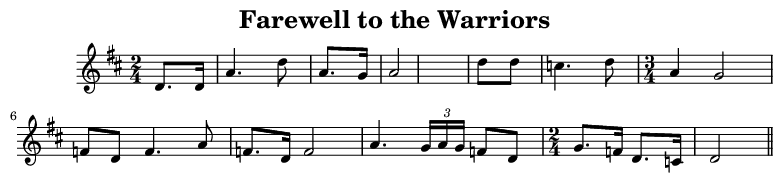

In [ ]:
# proper way to test working: unit-testing
show_score(scores[0])
play_score(scores[0])

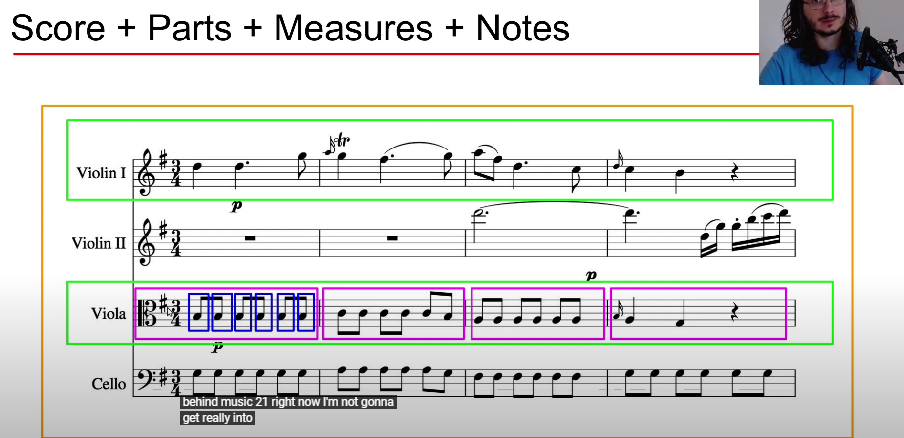

In [11]:
acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]

def has_acceptable_duration(score, acceptable_durations):
  """
  purpose: checking if duration of notes is acceptable
  params: score and list of desired durations
  returns: boolean
  """
  for note in score.flat.notesAndRests: # score is converted to a list of notes and rests
    if note.duration.quarterLength in acceptable_durations: 
      return True
    return False

In [12]:
# transposing score would improve pattern capture of the model rather than learn keys; will pediction be only in amin/cmaj

def transpose_score(score):
    """
    purpose: Transposes song to C maj/A min
    params: piece (m21 stream): Piece to transpose
    returns: transposed_song (m21 stream):
    """

    # get key from the song
    parts = score.getElementsByClass(music21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(music21.stream.Measure)
    key = measures_part0[0][4]
    
    # estimate key using music21 35 min
    key = score.analyze("key")

    # determine the amt of transpose required
    if key.mode == 'major':
      interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("C"))
    else:
      interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("A"))

    # transposing the note
    transposed_score = score.transpose(interval)

    return transposed_score

In [13]:
def encode_score(score, time_step = 0.25): # time_step = 0.25 case for 1/16th note
  """
  purpose: create time series data of transposed score
  params: score
  returns: midi based time series
  """

  encoded_score = []

  for event in score.flat.notesAndRests: # while encoding we only care about the notes and rests
    if type(event) == music21.note.Note:
      symbol = event.pitch.midi
    else:
      symbol = 'r'

    steps = event.duration.quarterLength / time_step # quartLength basically refers to a beat

    for step in range(int(steps)):
      if step == 0: # midi code at start of the event
        encoded_score.append(symbol)
      else: # rest of the duration we hold
        encoded_score.append('_')

  encoded_score = " ".join(map(str, encoded_score))

  return encoded_score

In [14]:
def save_file(path, subject):
  '''
  purpose: saving the encoded string
  params: save_location, encoded_song
  returns: None
  '''
  with open(path, "w") as file_ptr:
    file_ptr.write(subject)

In [ ]:
import os

In [15]:
def preprocess(scores):
  """
  purpose: preprocessing krn score
  params: parsed krn file
  returns: 
  """
  for index, score in enumerate(scores): # as a way, to properly index and store our encoded scores to 
    if index % 100 == 0: print(index)
    if has_acceptable_duration(score, acceptable_durations):
      transposed_score = transpose_score(score)
      encoded_score = encode_score(transposed_score)
      save_path = os.path.join("/content/drive/MyDrive/erk/erk_songs", str(index))
      save_file(save_path, encoded_score)
    else:
      print(f"{index} numbered file: not acceptable")

In [16]:
preprocess(scores) # done before

0
100
180 numbered file: not acceptable
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


NO need to run preprocess next time we have saved the preprocess file in a drive folder.

In [17]:
import shutil

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/erk/erk_songs"):
  for file in filenames:
    shutil.copy(os.path.join("/content/drive/MyDrive/erk/erk_songs", file),"/content/prel_erk")

In [18]:
# it will be easier to learn from the data presented all at once, rather than sequentially 1-2 min
# delimiter_length can even be lesser.

def unify_dataset(data_path, target_path = "/content/unified_erk_dataset", delimiter = '/ ', delimiter_length = 64):
  """
  purpose: unify the sequential datas (for improved pattern capture of the data by the network)
  params: path where the datafiles are located, path where the unified file is to be stored, *
  returns: unified_string/None decide
  """
  new_score_delimiter = delimiter * delimiter_length   # score_end indicator
  unified_string = ""

  for dirpath, dirnames, filenames in os.walk(data_path):
    for index, file in enumerate(filenames):
      with open(os.path.join(data_path, str(file)), 'r') as file_ptr: # the individual files are read
        unified_string += file_ptr.read()
        if index < len(filenames) - 1: # delimiter not to be applied after the last score
          unified_string += " " + new_score_delimiter


  with open(target_path, 'w') as file_ptr: # saving the unified string to a file
    file_ptr.write(unified_string)
  
  return unified_string


In [19]:
dataset_erk = []
dataset_erk = unify_dataset("/content/prel_erk") 
dataset_erk

'64 _ _ _ 69 _ _ _ 71 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 71 _ _ _ 68 _ _ _ _ _ _ _ 64 _ _ _ 67 _ _ _ 67 _ _ _ 65 _ _ _ 64 _ _ _ 69 _ _ _ 69 _ _ _ 68 _ _ _ 69 _ _ _ _ _ _ _ r _ _ _ 64 _ _ _ 69 _ _ _ 71 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 71 _ _ _ 68 _ _ _ _ _ _ _ 64 _ _ _ 67 _ _ _ 67 _ _ _ 65 _ _ _ 64 _ _ _ 69 _ _ _ 69 _ _ _ 68 _ _ _ 69 _ _ _ _ _ _ _ r _ _ _ 71 _ _ _ 72 _ _ _ 74 _ _ _ 76 _ _ _ 76 _ _ _ 74 _ _ _ 74 _ _ _ 72 _ _ _ 76 _ _ _ 74 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 55 _ _ _ 60 _ _ _ _ _ 62 _ 64 _ 65 _ 67 _ 69 _ 67 _ 72 _ 72 _ _ _ r _ _ _ 67 _ 72 _ 71 _ _ _ _ _ 69 _ 67 _ 65 _ 69 _ 67 _ 64 _ _ _ _ _ _ _ r _ _ _ 55 _ _ _ 60 _ _ _ _ _ 62 _ 64 _ 65 _ 67 _ 69 _ 67 _ 72 _ 72 _ _ _ r _ _ _ 67 _ 72 _ 71 _ _ _ _ _ 69 _ 67 _ 65 _ 69 _ 67 _ 64 _ _ _ _ _ _ _ r _ _ _ _ _ 67 _ 62 _ 67 _ 65 _ _ _ _ _ 62 _ 64 _ 69 _ 67 _ _ _ _ _ 64 _ 62 _ 67 _ 65 _

In [20]:
with open("/content/dataset_erk.txt", 'w') as handle:
  handle.write(dataset_erk)

In [ ]:
# check if non-desirable characters didn't creep in

valid_symbols = [str(ele) for ele in range(0, 200)]
valid_symbols += [' ', 'r', '_', '/']

def sanity_checked_string(dataset, allowed = valid_symbols):
  """
  purpose: to remove non-desirable characters
  params: dataset string, list of valid symbols
  returns: clean string
  """
  string = ''
  for symbol in dataset.split():
    if symbol not in valid_symbols:
      continue
    else:
      string += symbol + ' '

  return string[:-1]

In [ ]:
dataset = sanity_checked_string(dataset_erk, valid_symbols)

In [ ]:
with open("/content/unified_dataset_deutschl", 'w') as file_ptr:
  file_ptr.write(dataset_erk)

In [21]:
dataset_erk

'64 _ _ _ 69 _ _ _ 71 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 71 _ _ _ 68 _ _ _ _ _ _ _ 64 _ _ _ 67 _ _ _ 67 _ _ _ 65 _ _ _ 64 _ _ _ 69 _ _ _ 69 _ _ _ 68 _ _ _ 69 _ _ _ _ _ _ _ r _ _ _ 64 _ _ _ 69 _ _ _ 71 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 71 _ _ _ 68 _ _ _ _ _ _ _ 64 _ _ _ 67 _ _ _ 67 _ _ _ 65 _ _ _ 64 _ _ _ 69 _ _ _ 69 _ _ _ 68 _ _ _ 69 _ _ _ _ _ _ _ r _ _ _ 71 _ _ _ 72 _ _ _ 74 _ _ _ 76 _ _ _ 76 _ _ _ 74 _ _ _ 74 _ _ _ 72 _ _ _ 76 _ _ _ 74 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 55 _ _ _ 60 _ _ _ _ _ 62 _ 64 _ 65 _ 67 _ 69 _ 67 _ 72 _ 72 _ _ _ r _ _ _ 67 _ 72 _ 71 _ _ _ _ _ 69 _ 67 _ 65 _ 69 _ 67 _ 64 _ _ _ _ _ _ _ r _ _ _ 55 _ _ _ 60 _ _ _ _ _ 62 _ 64 _ 65 _ 67 _ 69 _ 67 _ 72 _ 72 _ _ _ r _ _ _ 67 _ 72 _ 71 _ _ _ _ _ 69 _ 67 _ 65 _ 69 _ 67 _ 64 _ _ _ _ _ _ _ r _ _ _ _ _ 67 _ 62 _ 67 _ 65 _ _ _ _ _ 62 _ 64 _ 69 _ 67 _ _ _ _ _ 64 _ 62 _ 67 _ 65 _

In [46]:
from google.colab import files
import json

In [23]:
# 'r', '/'. ' ' and '_' are not understandable by the NN, need to convert them into appropriate format.

def create_mapping(dataset, mapping_path = "mapping.json"):
  """
  purpose: create NN understable data(only numerical)
  params: unified_string, location where the map is to be stored
  returns: None
  """
  dictionary = list(set(dataset.split(" "))) # identify all unique events 
  print(dictionary)
  
  map = {}
  for index, event in enumerate(dictionary): # creating the mapping
    map[event] = index

  with open(mapping_path, 'w') as file_ptr:
    json.dump(map, file_ptr)

In [24]:
create_mapping(dataset_erk)

['73', '68', '46', '83', '80', '59', '57', '78', '64', '62', '58', '50', '69', '74', '86', '71', '43', '55', '79', '75', '_', '77', '60', '49', '53', '40', '61', '81', '52', 'r', '63', '/', '67', '70', '45', '41', '84', '76', '65', '47', '54', '48', '72', '66']


In [25]:
files.download("mapping.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import json

In [27]:
map = {}
with open("mapping.json", 'r') as file_ptr:
  # map = file_ptr.read() # leads to dict encoded as a string
  map = json.load(file_ptr) 

In [45]:
import shutil
colab_link = "/content/mapping.json"
gdrive_link = "/content/drive/MyDrive/erk"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/erk/mapping.json'

In [28]:
map

{'73': 0,
 '68': 1,
 '46': 2,
 '83': 3,
 '80': 4,
 '59': 5,
 '57': 6,
 '78': 7,
 '64': 8,
 '62': 9,
 '58': 10,
 '50': 11,
 '69': 12,
 '74': 13,
 '86': 14,
 '71': 15,
 '43': 16,
 '55': 17,
 '79': 18,
 '75': 19,
 '_': 20,
 '77': 21,
 '60': 22,
 '49': 23,
 '53': 24,
 '40': 25,
 '61': 26,
 '81': 27,
 '52': 28,
 'r': 29,
 '63': 30,
 '/': 31,
 '67': 32,
 '70': 33,
 '45': 34,
 '41': 35,
 '84': 36,
 '76': 37,
 '65': 38,
 '47': 39,
 '54': 40,
 '48': 41,
 '72': 42,
 '66': 43}

In [29]:
unified_string = ''
with open("/content/dataset_erk.txt", 'r') as file_ptr:
  unified_string = file_ptr.read()

In [30]:
# mapping our songs to map we generated

def NN_feedable_data_convertor(unified_string):
  """
  purpose: converts string to list(feedable to NN)
  params: unified_string
  returns: NN feedable data
  """
  feedable_data = []
  count = 0
  unified_list = dataset_erk.split(" ")
  for event in unified_list:
    count += 1
    if count % 10000 == 0: print(count)
    feedable_data.append(map[event])

  return feedable_data

In [31]:
feedable_data = NN_feedable_data_convertor(unified_string)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000


In [33]:
import pickle
with open('/content/drive/MyDrive/erk/feedable_data.pkl', 'wb') as file_ptr:
  pickle.dump(feedable_data, file_ptr, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

In [ ]:
# with open('/content/feedable_data.pkl', 'rb') as handle:
#     feedable_data = pickle.load(handle)

In [ ]:
len(map)

59

In [34]:
import numpy as np

In [35]:
# 32 notes at once: 2 bars as input; use this to predict the next note; slide the window forward and predict next; till end  
# https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

def generate_training_sequences(feedable_data, sequence_length = 64): # 64 causing crash
  inputs = []
  targets = []

  for count in range(len(feedable_data) - sequence_length):
    inputs.append(feedable_data[count: count + sequence_length]) # input features one at a time: inside
    targets.append(feedable_data[count + sequence_length]) # correspondingtarget value: inside

  inputs = np.array(inputs) # very important to convert to array; list causes crash; large size
  targets = np.array(targets)

  return inputs, targets

In [36]:
inputs, targets = generate_training_sequences(feedable_data, 64)

In [37]:
len(inputs)

365520

In [38]:
# https://stackoverflow.com/a/33245595/19817062

import pickle
your_data = inputs

# Store data (serialize)
with open('/content/drive/MyDrive/erk/inputs_erk.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# https://stackoverflow.com/a/33245595/19817062

import pickle
your_data = targets

# Store data (serialize)
with open('/content/drive/MyDrive/erk/targets_erk.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
import shutil
shutil.copy("/content/drive/MyDrive/erk/inputs_erk.pickle", "/content/inputs_erk.pickle",)

'/content/inputs_erk.pickle'

In [43]:
inputs

array([[ 8, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20,  1],
       [20, 20, 12, ..., 20,  1, 20],
       ...,
       [20, 22, 20, ..., 20, 20, 29],
       [22, 20, 22, ..., 20, 29, 20],
       [20, 22, 20, ..., 29, 20, 20]])

In [44]:
targets

array([ 1, 20, 20, ..., 20, 20, 20])

To be run on kaggle

In [ ]:
!pip install gdown
!gdown --id 1KQsSxrVshYIqXXYVys7moGWqcv3rIM60
!gdown --id 1KSp8hHEVF6JSFvDxfc8sXkgecSWH1xQF

In [ ]:
!pip install pickle5
import pickle5 as pickle

In [ ]:
with open('/kaggle/working/inputs_deutschl.pickle', 'rb') as handle:
    inputs_deutschl = pickle.load(handle)

In [ ]:
with open('/kaggle/working/inputs_deutschl.pickle', 'rb') as handle:
    inputs_deutschl = pickle.load(handle)

In [ ]:
from tensorflow import keras as keras
import json

In [ ]:
map = {}
with open("/kaggle/input/ok1234/mapping_deutschl.json", 'r') as file_ptr:
  map = json.load(file_ptr) 

In [ ]:
one_hot_encoded_inputs = keras.utils.to_categorical(inputs_deutschl, num_classes = len(map))